In [1]:
from swift_control.data import (
    create_grid_data,
    training_data_gen,
    xdot_training_data_gen,
)
from swift_control.eval import eval_cs
from swift_control.train import train_episodic
from plant_factory import ControllerFactory
import numpy as np
import mosek
from swift_control.init_gpc import init_gpcontroller
from gp_factory.init_gp import init_trained_gp

In [2]:
swift_path = "/share/dean/fast_control/models/swift_grid/"
plant_conf = swift_path + "base_config.toml"

x_0 = np.array([2.0, 0.0, 0.0, 0.0])

plant = ControllerFactory(plant_conf)
kwargs = x_0, plant.episodic_T, plant.episodic_num_steps

oracle_cs, ts = eval_cs(plant.system, plant.oracle_controller, *kwargs)
qp_cs, _ = eval_cs(plant.system, plant.qp_controller, *kwargs)


c_cdot = 0

In [3]:
grid_data = np.load(swift_path + "grid_data.npz").values()
confs = []
gp_controller_pair = []
gp_cs = []
names = []
for i in range(1, 5):
    model_conf = swift_path + f"m{i}_config.toml"
    gp = init_trained_gp(model_conf, grid_data)
    gp_controller = init_gpcontroller(plant, gp)
    model_cs, _ = eval_cs(plant.system, gp_controller, *kwargs)

    confs.append(model_conf)
    gp_controller_pair.append((gp_controller, gp))
    gp_cs.append(model_cs)
    names.append(gp_controller.name)

data size:10963, calculated rf_d is: 2436
gp_name: ad_rf, training time: 3.9552128269860987
gp_name: ad_kernel, training time: 99.04429847100982
data size:10963, calculated rf_d is: 2436
gp_name: adp_rf, training time: 41.98073925200151
gp_name: adp_kernel, training time: 96.95666733701364


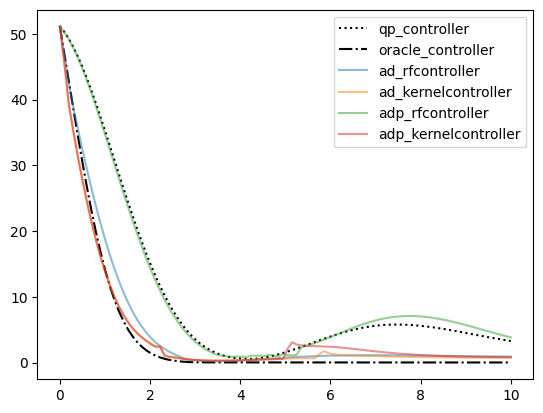

In [4]:
import seaborn as sns

sns.lineplot(
    x=ts,
    y=qp_cs[c_cdot],
    linestyle="dotted",
    color="black",
    label="qp_controller",
)
sns.lineplot(
    x=ts,
    y=oracle_cs[c_cdot],
    linestyle="dashdot",
    color="black",
    label="oracle_controller",
)
for model_cs, name in zip(gp_cs, names):
    sns.lineplot(
        x=ts,
        y=model_cs[c_cdot],
        label=name,
        alpha=0.5,
    )